In [2]:
import json
import pandas as pd

f = open('validation_set.json',)
validation_df = json.load(f)
print("validation set size: {}".format(len(validation_df)))
#print(validation_df[0])

flavor_df = json.load(open('flavor_DB.json',))
flavorlist=[]
for i in range(len(flavor_df)):
    flavorlist.append(flavor_df[i]['entity_alias_readable']) 
    
print("# of unique flavors: {}".format(len(flavorlist)))

validation set size: 100
# of unique flavors: 934


In [32]:
from thefuzz import fuzz
from thefuzz import process
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

##for a single ingredient match against all flavors. find match with best ratio. output that flavor.
from Levenshtein import distance as lev
from collections import defaultdict
import time

class stringmatch(object):
    def __init__(self, flavor_df):
        self.flavorlist=[]
        for i in range(len(flavor_df)):
            self.flavorlist.append(flavor_df[i]['entity_alias_readable']) 
    def shortenstring(self,text,i):
        return (','.join(text.split(',')[:i]))
    def flavormatch(self,ingredient, xlimit=1):
        #print("input ingredient: {}".format(ingredient))
        match = process.extract(ingredient, self.flavorlist, limit=xlimit)
        #print("best matches: {}".format(match))
        return match
    def flavormatch1(self,ingredient, flavorlist):
        ingredient_s=shortenstring(ingredient,1)
        match = process.extractOne(ingredient_s, flavorlist)
        return match[0]
    def flavormatch2(self,ingredient, flavorlist):
        ingredient_s=shortenstring(ingredient,2)
        match = process.extractOne(ingredient_s, flavorlist)
        return match[0]
    def flavormatch3(self,ingredient, flavorlist):
        ingredient_s=shortenstring(ingredient,3)
        match = process.extractOne(ingredient_s, flavorlist)
        return match[0]
    def flavormatch4(self,ingredient, flavorlist):
        match = process.extractOne(ingredient, flavorlist, scorer=fuzz.token_sort_ratio)
        return match[0]
    def flavormatch5(self,ingredient, flavorlist):
        match = process.extractOne(ingredient, flavorlist, scorer=fuzz.token_set_ratio)
        return match[0]
    def levmatch(self,ingredient,matches,num=2):
        scores=defaultdict(int)
        for i in range(len(matches)):

            scores[matches[i]]=lev(ingredient,matches[i])
        max_keys = sorted(scores, key=scores.get)[:3]
        print("input ingredient: {}".format(ingredient))
        print("best matches: {}".format(max_keys))
    def to_list(self,validation_df):  #input is validation_df
        val_set=[]
        val_labels=[]
        for i in validation_df:
            for j in i['ingredients']:
                val_set.append(j['text'])
            for j in i['ingredients_flavormatch']:
                val_labels.append(j['text'])
        return val_set,val_labels

    def accuracy(self,pred, labels): #compare 2 lists
        assert len(pred)==len(labels)
        total=len(pred)
        matches=0
        misses=0
        for i in range(total):
            if pred[i]==labels[i]:
                matches+=1
            else:
                misses+=1
        accuracy=matches/total
        return accuracy

    def display_confusion_matrix(self,pred,labels):
        assert len(pred)==len(labels)
        total=len(pred)
        return confusion_matrix(pred, labels)

In [121]:
z=stringmatch(flavor_df)
val_set,val_labels=z.to_list(validation_df)

def accuracy(function_name, zlimit):
compare = pd.DataFrame(
    {'index': compare.index,
     'input': val_set,
    'actual labels': val_labels})
zlimit=3
val_predictions=[]
for i in val_set:
    val_predictions.append(z.flavormatch(i,zlimit))
    #compare["predictions"]=compare["input"].apply(lambda x: z.flavormatch(i,zlimit))
#acc0=accuracy(val_labels,val_predictions)  
alg="flavormatch"
for i in range(zlimit):
    compare[alg+str(i)]=compare["index"].apply(lambda x: val_predictions[x][i][0])
compare[alg+"_match?"]=compare.drop("actual labels", 1).isin(compare["actual labels"]).any(1)
compare[alg+"_match?"]=compare[alg+"_match?"].astype(int)
acc=compare[alg+"_match?"].sum()/len(compare[alg+"_match?"])
print(acc)

0.8258785942492013


In [113]:
compare[alg+"_match?"]=compare[alg+"match?"].astype(int)

In [114]:
compare.head()

,index,input,actual labels,flavormatch0,flavormatch1,flavormatch2,flavormatchmatch?
0,0,"wheat flour, white, all-purpose, unenriched",Flour,White Bread,White Wine,White Currant,0
1,1,"leavening agents, baking soda",Leavening agent,Leavening agent,Nuts,Lingcod,1
2,2,"butter, without salt",Butter,Butter,Salt,Peanut Butter,1
3,3,"cream, sour, cultured",Cream,Cream,Cream Cheese,Sour Cherry,1
4,4,"corn, sweet, white, raw",Corn,Corn,White Bread,White Wine,1


In [119]:
acc=compare[alg+"match?"].sum()/len(compare[alg+"match?"])
acc

0.8258785942492013

In [7]:
##this cell can take a few minutes
##Use algorithm 0 - fuzzy wuzzy defaults
val_predictions=[]
for i in val_set:
    val_predictions.append(flavormatch(i, flavorlist))
acc0=accuracy(val_labels,val_predictions)  
"""
val_predictions1=[] #fuzzy wuzzy remove extraneous info, separated by comma, first 1
for i in val_set:
    val_predictions1.append(flavormatch1(i, flavorlist))
acc1=accuracy(val_labels,val_predictions1)  

##Use algorithm 2 - fuzzy wuzzy remove extraneous info, separated by comma, first 2
val_predictions2=[]
for i in val_set:
    val_predictions2.append(flavormatch2(i, flavorlist))
acc2=accuracy(val_labels,val_predictions2)  

##Use algorithm 3 - fuzzy wuzzy remove extraneous info, separated by comma, first 3
val_predictions3=[]
for i in val_set:
    val_predictions3.append(flavormatch3(i, flavorlist))
acc3=accuracy(val_labels,val_predictions3)  

##Use algorithm 4 - fuzzy wuzzy token sort ratio
val_predictions4=[]
for i in val_set:
    val_predictions4.append(flavormatch4(i, flavorlist))
acc4=accuracy(val_labels,val_predictions4)  

##Use algorithm 5 - fuzzy wuzzy token set ratio
val_predictions5=[]
for i in val_set:
    val_predictions5.append(flavormatch5(i, flavorlist))
acc5=accuracy(val_labels,val_predictions5)  

"""
print(acc0)
#print(acc1)
#print(acc2)
#print(acc3)
#print(acc4)
#print(acc5)
##algorithm 0 - fuzzy wuzzy defaults
##algorithm 1 - fuzzy wuzzy remove extraneous info, separated by comma, first 1
##algorithm 2 - fuzzy wuzzy remove extraneous info, separated by comma, first 2
##algorithm 3 - fuzzy wuzzy remove extraneous info, separated by comma, first 3
##algorithm 4 - fuzzy wuzzy fuzzy wuzzy token sort ratio
##algorithm 5 - fuzzy wuzzy fuzzy wuzzy token set ratio

0.744408945686901


In [3]:


compare = pd.DataFrame(
    {'input': val_set,
    'actual labels': val_labels,
     'predictions1': val_predictions1,
     'predictions2': val_predictions2,
     'predictions3': val_predictions3,
     'predictions4': val_predictions4,
     'predictions5': val_predictions5,
     'predictions6': val_predictions6
    })
compare['p1'] = compare.apply(lambda x: int(x['predictions1']==x['actual labels']), axis=1)
compare['p2'] = compare.apply(lambda x: int(x['predictions2']==x['actual labels']), axis=1)
compare['p3'] = compare.apply(lambda x: int(x['predictions3']==x['actual labels']), axis=1)
compare['p4'] = compare.apply(lambda x: int(x['predictions4']==x['actual labels']), axis=1)
compare['p5'] = compare.apply(lambda x: int(x['predictions5']==x['actual labels']), axis=1)
compare['p6'] = compare.apply(lambda x: int(x['predictions6']==x['actual labels']), axis=1)

compare.tail(40)

NameError: name 'val_set' is not defined

In [205]:
#finds all unique labels from val_predictions and val_labels joied
unique=list(set(val_labels))+list(set(val_predictions2)-set(val_labels))
cm=confusion_matrix(val_predictions2, val_labels,labels=unique)

In [204]:
len(unique)

139

<AxesSubplot:>

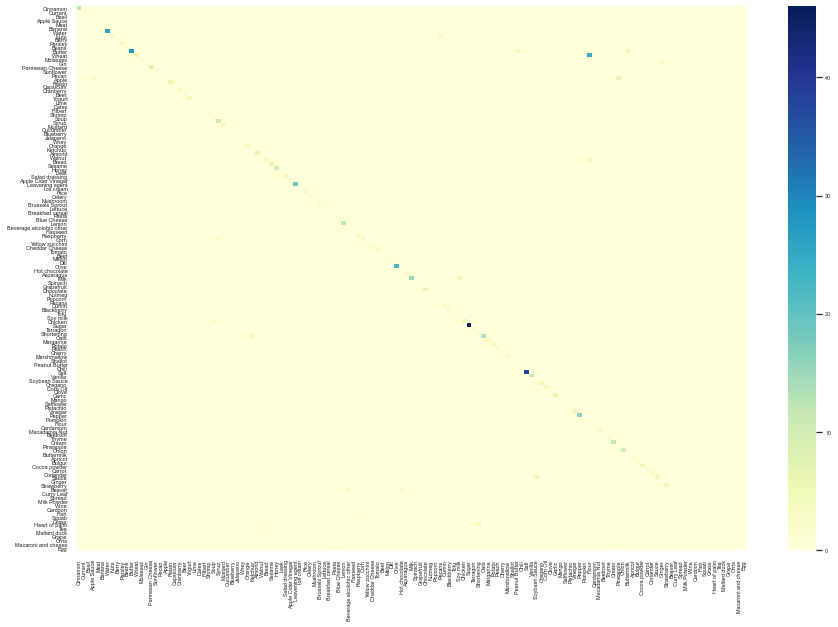

In [210]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.set(font_scale=.5)
sns.heatmap(cm, cmap="YlGnBu",xticklabels=unique, yticklabels=unique)

In [197]:
unique=compare[compare['p3']>0]['actual labels']
len(list(unique))

398

In [136]:
total=len(val_set)
for i in range(total):
    print(val_predictions[i],val_labels[i])

Wheat Flour
Leavening agent Leavening agent
Butter Butter
Cream Cream
Corn Corn
Rice Rice
Soft drink Bread
Nuts Almond
Sweet Grass Raisin
Cinnamon Cinnamon
Syrup Syrup
Olive Olive
Vanilla Vanilla
Milk Milk
Olive Olive
Molasses Molasses
Bread Bread
Wheat Flour
Yellow zucchini Corn
Salt Salt
Leavening agent Leavening agent
Cocoa Cocoa powder
Strawberry Jam Strawberry
Frankfurter Sausage Sugar
Lemon Lemon
Butter Butter
Sauce Sauce
Allspice Capsicum
Pepper Pepper
Salt Salt
Garlic Garlic
Onion Onion
Pepper Pepper
Pepper Walnut
Nuts Capsicum
Frankfurter Sausage Sugar
Sweet Potato Potato
Water Water
Wheat Flour
Leavening agent Leavening agent
Salt Salt
Milk Milk
Frankfurter Sausage Sugar
Water Water
Butter Butter
Cheese Cheddar Cheese
Onion Onion
Mustard Mustard
Banana Banana
Wheat Wheat
Cocoa Cocoa powder
Brown bear Sugar
Salt Salt
Leavening agent Leavening agent
Leavening agent Leavening agent
Vanilla Soy milk
Oil-seed Camellia Apple Sauce
Salt Margarine
Butter Peanut Butter
Red Sage Sugar
